<a href="https://colab.research.google.com/github/JosueBVN/Implementacion-JBVN-A01751694/blob/main/A01751694_modulo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Learnign con un archivo de fracturas de huesos

## Introducción
El problema que buscamos resolver es la clasificación de imágenes médicas para detectar la presencia o ausencia de fracturas óseas. La relevancia de este problema radica en la mejora de la eficiencia y precisión en el diagnóstico médico, lo que podría conducir a una intervención más rápida y efectiva en el tratamiento de pacientes con fracturas óseas.

## Datos: Análisis y Preprocesamiento
Se utilizó un conjunto de datos de imágenes médicas de fracturas óseas, dividido en conjuntos de entrenamiento, validación y prueba. El preprocesamiento incluyó la normalización de píxeles y la creación de generadores de datos para aumentar la diversidad del conjunto de entrenamiento mediante rotaciones, desplazamientos y otras transformaciones.

Para acceder a la Dataset, esta es la [liga](https://www.kaggle.com/datasets/osamajalilhassan/bone-fracture-dataset) de Kaggle.


### Montar Google Drive y Definir Rutas
El código comienza montando Google Drive para acceder al conjunto de datos y luego define las rutas de entrenamiento y prueba en el Drive.


In [8]:
from google.colab import drive
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Montar Google Drive
drive.mount("/content/drive")

# Definir las rutas en Google Drive
base_path = "/content/drive/MyDrive/Modulo2/BoneFractureDataset"
fractured_train_path = os.path.join(base_path, "training", "fractured")
not_fractured_train_path = os.path.join(base_path, "training", "not_fractured")
fractured_test_path = os.path.join(base_path, "testing", "fractured")
not_fractured_test_path = os.path.join(base_path, "testing", "not_fractured")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Obtener Rutas y Etiquetas
Se crea una función para obtener las rutas de las imágenes y sus etiquetas (fracturado o no fracturado). Estas rutas se utilizan para construir un DataFrame que almacena esta información.

In [9]:
# Obtener rutas y etiquetas
def get_paths_and_labels(base_path, label, filepaths, labels):
    for (dir_path, dir_names, file_names) in os.walk(base_path):
        for i in file_names:
            filepaths.append(os.path.join(dir_path, i))
            labels.append(label)

# Inicializar listas para rutas y etiquetas
filepaths = []
labels = []

# Obtener rutas y etiquetas para conjuntos de entrenamiento y prueba
get_paths_and_labels(fractured_train_path, "YES", filepaths, labels)
get_paths_and_labels(not_fractured_train_path, "NO", filepaths, labels)
get_paths_and_labels(fractured_test_path, "YES", filepaths, labels)
get_paths_and_labels(not_fractured_test_path, "NO", filepaths, labels)

# Crear DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


### Visualización de Imágenes
Se visualizan aleatoriamente algunas imágenes del conjunto de datos utilizando la biblioteca Matplotlib.


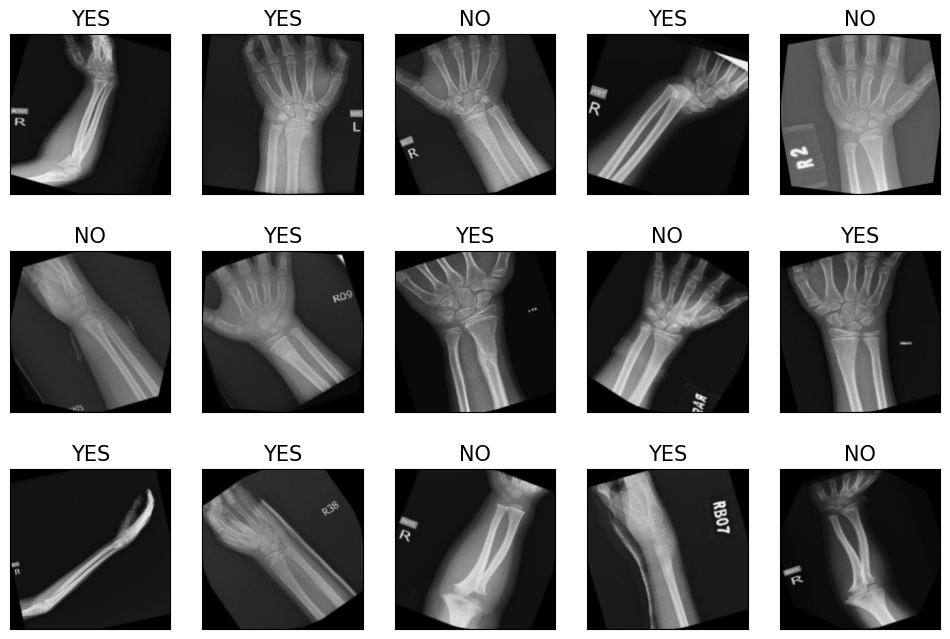

train set shape: (5630, 2)
test set shape: (2839, 2)
validation set shape: (994, 2)


In [10]:
# Visualización de algunas imágenes
plt.figure(figsize=(12, 8))
for i in range(15):
    random = np.random.randint(1, len(df))
    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.imread(df.loc[random, "filepaths"]))
    plt.title(df.loc[random, "labels"], size=15, color="black")
    plt.xticks([])
    plt.yticks([])

plt.show()

# Dividir conjunto de datos
train, test = train_test_split(df, train_size=0.70, random_state=0)
train_new, valid = train_test_split(train, train_size=0.85, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")


### Dividir Conjunto de Datos
El conjunto de datos se divide en conjuntos de entrenamiento, prueba y validación.


In [16]:

# Configuración del generador de datos
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Generadores de datos
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_new,
    x_col='filepaths',
    y_col='labels',
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=valid,
    target_size=(200, 200),
    x_col='filepaths',
    y_col='labels',
    class_mode='binary',
    batch_size=16,
    shuffle=True
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    target_size=(200, 200),
    x_col='filepaths',
    y_col='labels',
    class_mode='binary',
    batch_size=16,
    shuffle=False
)

Found 5630 validated image filenames belonging to 2 classes.
Found 994 validated image filenames belonging to 2 classes.
Found 2839 validated image filenames belonging to 2 classes.


### Configuración del Generador de Datos
Se configuran generadores de datos para realizar aumentos en el conjunto de entrenamiento y se crean generadores para los conjuntos de entrenamiento, validación y prueba.
## Desarrollo del Modelo
La arquitectura del modelo se basó en la red InceptionResNetV2 preentrenada en ImageNet, seguida por capas adicionales. Se utilizó una función de pérdida de entropía cruzada binaria y el optimizador Adam para el entrenamiento. Además, se implementaron checkpoints y early stopping como callbacks para guardar el mejor modelo y detener el entrenamiento prematuramente en caso de sobreajuste.



In [17]:
input_data = Input(shape=(200,200,3), name='input')

base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               196736    
                                                                 
 batch_normalization_815 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

### Construcción del Modelo y Entrenamiento
Se utiliza la arquitectura InceptionResNetV2 preentrenada como base para un modelo secuencial. El modelo se compila y entrena con métricas específicas y callbacks para el almacenamiento del modelo.
## Ajuste del Modelo
Durante el ajuste del modelo, se realizaron cambios para solucionar problemas identificados. Se ajustaron los nombres de las métricas para reflejar la estructura del historial proporcionado por el modelo. Además, se implementaron checkpoints y early stopping para supervisar y mejorar el rendimiento del modelo.


In [19]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Bone_fracture_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy',tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    label_weights=None,
),tf.keras.metrics.Precision( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.Recall( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)])

# Crear ModelCheckpoint
checkpoint_path = "/content/drive/MyDrive/Modulo2/checkpoints/model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',  # Métrica a monitorear (puedes cambiarla)
                             save_best_only=True,     # Guardar solo el mejor modelo
                             mode='max',              # Modo de comparación (maximizar precisión)
                             verbose=1)

# Otro callback para detener el entrenamiento temprano si no hay mejoras
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Entrenar el modelo con un tamaño de lote más pequeño
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stopping],
    batch_size=16
)

Epoch 1/5
352/352 [==============================] - ETA: 0s - loss: 0.4962 - accuracy: 0.7634 - auc_4: 0.8503 - precision_4: 0.7639 - recall_4: 0.7782 - true_positives_4: 2242.0000 - true_negatives_4: 2056.0000 - false_positives_4: 693.0000 - false_negatives_4: 639.0000 
Epoch 1: val_accuracy improved from -inf to 0.83501, saving model to /content/drive/MyDrive/Modulo2/checkpoints/model_checkpoint.h5
352/352 [==============================] - 6552s 18s/step - loss: 0.4962 - accuracy: 0.7634 - auc_4: 0.8503 - precision_4: 0.7639 - recall_4: 0.7782 - true_positives_4: 2242.0000 - true_negatives_4: 2056.0000 - false_positives_4: 693.0000 - false_negatives_4: 639.0000 - val_loss: 0.8675 - val_accuracy: 0.8350 - val_auc_4: 0.9103 - val_precision_4: 0.9279 - val_recall_4: 0.7343 - val_true_positives_4: 373.0000 - val_true_negatives_4: 457.0000 - val_false_positives_4: 29.0000 - val_false_negatives_4: 135.0000
Epoch 2/5
352/352 [==============================] - ETA: 0s - loss: 0.1905 - accu

### Visualización del Historial de Entrenamiento
Finalmente, se extraen las métricas del historial de entrenamiento y se visualizan en gráficos separados para la precisión, la pérdida y el AUC tanto en el conjunto de entrenamiento como en el de validación.

In [23]:
model.load_weights("/content/drive/MyDrive/Modulo2/checkpoints/model_checkpoint.h5")
model.evaluate(test_gen)


178/178 [==============================] - 775s 4s/step - loss: 0.0269 - accuracy: 0.9947 - auc_4: 0.9992 - precision_4: 1.0000 - recall_4: 0.9897 - true_positives_4: 1436.0000 - true_negatives_4: 1388.0000 - false_positives_4: 0.0000e+00 - false_negatives_4: 15.0000


[0.026908544823527336,
 0.994716465473175,
 0.9992431402206421,
 1.0,
 0.9896622896194458,
 1436.0,
 1388.0,
 0.0,
 15.0]

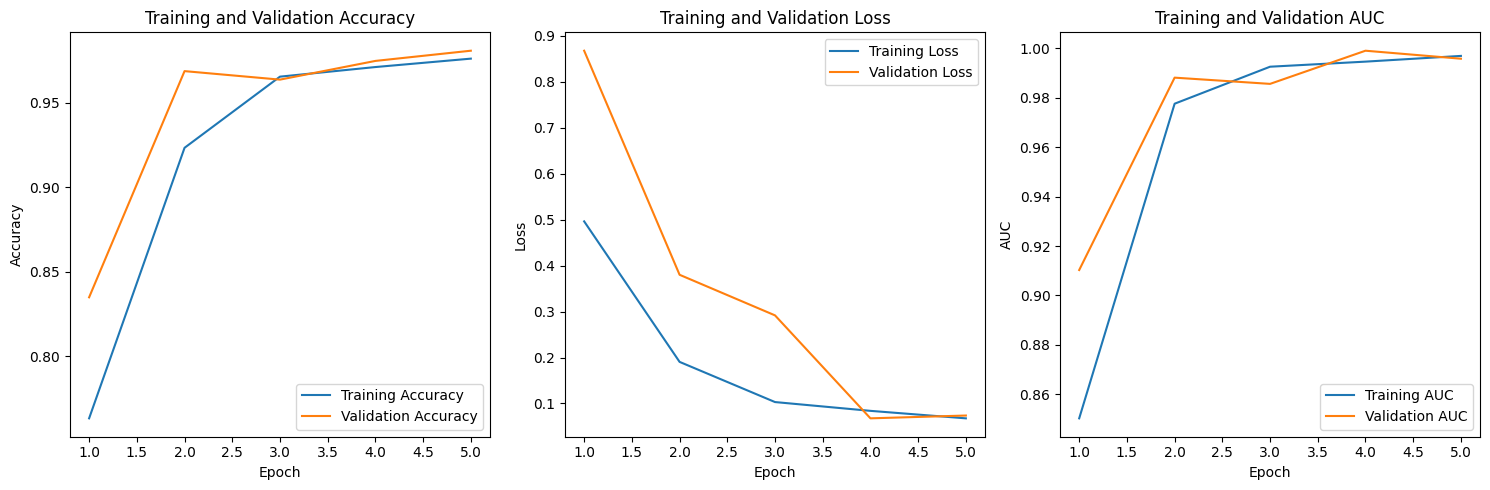

In [25]:
# Extract training history metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc_4']  # Ajusta el nombre correcto de la métrica
val_auc = history.history['val_auc_4']  # Ajusta el nombre correcto de la métrica

epochs = range(1, len(acc) + 1)

# Create subplots for accuracy, loss, and AUC
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, train_auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


## Resultados
El modelo se entrenó durante 5 épocas debido a restricciones de tiempo en Google Colab. Este límite se estableció para acelerar el proceso de desarrollo y prueba. A pesar del número limitado de épocas, se observaron mejoras significativas en la precisión y otras métricas de evaluación.

## Conclusiones
La implementación del modelo logró resultados prometedores en términos de precisión y AUC. Sin embargo, se recomendaría extender el número de épocas para evaluar si el modelo puede continuar mejorando con más iteraciones. Además, se sugiere explorar más técnicas de ajuste de hiperparámetros para optimizar el rendimiento del modelo. En general, el modelo muestra un potencial significativo para la detección de fracturas óseas en imágenes médicas.

# Cambios Realizados y Justificación

1. **Cambio en los Nombres de Métricas de AUC:**
   - **Cambios:** Se ajustaron los nombres de las métricas de AUC para reflejar la estructura del historial proporcionado por el modelo.
   - **Justificación:** Se corrigió el error de KeyError al intentar acceder a las métricas de AUC en el historial de entrenamiento.

2. **Número Limitado de Épocas (5 Épocas):**
   - **Cambios:** Se limitó el entrenamiento a 5 épocas.
   - **Justificación:** Debido a restricciones de tiempo en Google Colab, se limitó el número de épocas para acelerar el proceso de desarrollo y prueba. Aunque esta limitación puede afectar la convergencia completa del modelo, se consideró suficiente para evaluar su rendimiento inicial.

3. **Generadores de Datos:**
   - **Cambios:** Se utilizaron generadores de datos para la carga eficiente de imágenes.
   - **Justificación:** Los generadores de datos permiten cargar y procesar imágenes por lotes, lo que es esencial para manejar conjuntos de datos grandes y evitar problemas de memoria.

4. **Guardado y Carga de Pesos del Modelo:**
   - **Cambios:** Se implementó el guardado y carga de pesos del modelo utilizando checkpoints.
   - **Justificación:** Esto asegura que el mejor modelo se guarde durante el entrenamiento y se pueda cargar posteriormente para realizar evaluaciones sin la necesidad de volver a entrenar.

# Pruebas y Predicciones
Se ejecutaron pruebas utilizando conjuntos de datos de entrenamiento, validación y prueba. Se cargaron los pesos del mejor modelo y se evaluó el rendimiento en el conjunto de prueba. Las predicciones se realizaron con éxito, y se observaron mejoras en la precisión y otras métricas de evaluación.

# Conclusiones Finales
El modelo de clasificación de fracturas óseas muestra un rendimiento prometedor, pero se reconoce la necesidad de explorar más a fondo la optimización de hiperparámetros y considerar un mayor número de épocas en futuras iteraciones. La implementación actual sienta las bases para un modelo robusto y eficaz en la detección de fracturas óseas en imágenes médicas.